## Numerical solution of the radiative transfer equation 

#### And what t do with it 

In this exercise, we will get familiar with spectrum calculation (modeling).

To calculate the spectrum of the object in question we need the following: 

- To choose a line of sight, the straight line we are solving RTE along 
- To specify a boundary condition or: incoming intensity on the "other" side of the object. 
- Opacity and emissivity variation over the line of sight so that we can solve RTE:

$$\frac{dI_\lambda}{dl} = \eta_\lambda - \chi_\lambda I_\lambda $$

- we knew this equation in the form:

$$\frac{1}{\rho}\frac{dI_\lambda}{dl} = j_\lambda - \kappa_\lambda I_\lambda $$

#### In our case we will: 

- Use atmospheric normal as a line of sight, that is, we will start at the bottom of the solar atmosphere and go straight "up", solving RTE along that line of sight
- Use the Blackbody radiation at the appropriate temperature (see below) as a boundary condition at the "bottom" of the atmosphere
- Instead of using directly opacity and emissivity (but see independent work), we will specify a somewhat ad hoc optical depth and source function and solve:

$$\frac{dI_\lambda}{d\tau_\lambda} = I_\lambda - S_\lambda $$

All these will come from a model atmosphere we will load and use here.

#### A little sketch to put everything in context (yes I love drawing :)) 

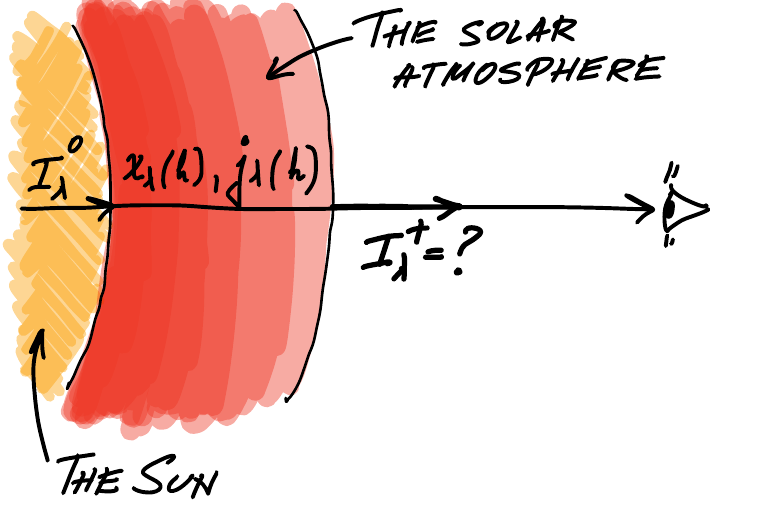

### Step zero: import python modules you are going to use. 

In [1]:
import numpy as np # basic mathematical and numerical functionallity 
import matplotlib.pyplot as plt # some plotting functionallity, for various things we will do

import matplotlib
matplotlib.rcParams.update({
    "text.usetex": False,
    "font.size" : 16,})

# This last line will give us a little bit nicer plot labeling

### Step one: load the "model" atmosphere and visualize it! 

We did not talk about this earlier but model atmosphere is basically just an array of values of physical quantities of interest on a depth grid, the one we are loading has total od 12 tabulated values, and the ones we are currently interested in are:

- 0 - Optical depth in the continuum, which is our "referent" wavelength or "referent" opacity  (in log scale) 
- 1 - Height in cm 
- 2 - Temperature 
- 3 - Gas presure 
- 4 - Electron pressure

Note - all the units are in the so called CGS system

For the moment we can live without the others, let's load famous FALC model from Fontenla et. al. (1993) and visualize it:

In [2]:
atmos = np.loadtxt("falc.dat",unpack=True,skiprows=1)

# Doing atmos.shape will show us the dimensions of the array. 
# It's usually the easiest way to see if everything is ok with the data 

atmos.shape

(12, 57)

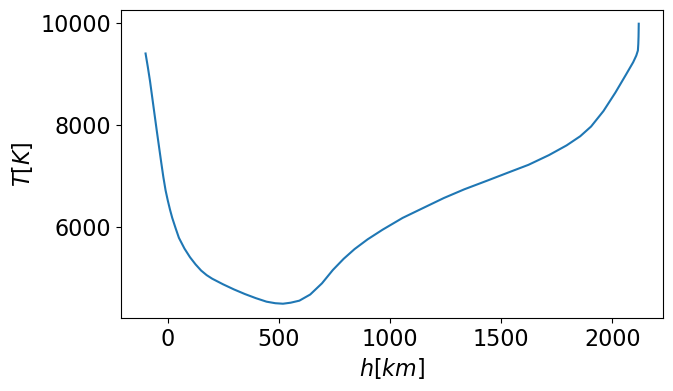

In [3]:
# The next easiest way to see if everything is ok with the data is to just plot it 
# Let's plot variation of temperature with height

z = np.copy(atmos[1]) / 1E5 # I am using np.copy so as not to disturb the original array
T = np.copy(atmos[2])

plt.figure(figsize=[7,4])
plt.plot(z,T)
plt.xlabel("$h [km]$")
plt.ylabel("$T [K]$")
plt.savefig("t_vs_z.png", bbox_inches='tight')

Text(0, 0.5, '$p$')

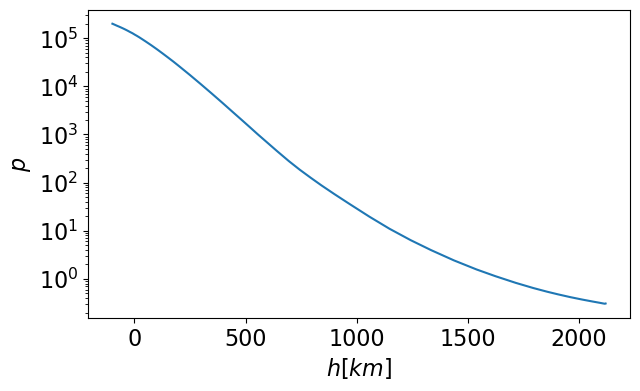

In [8]:
p = np.copy(atmos[3]) # This is now total gas pressure that is related to the total number density of all the particles
plt.figure(figsize=[7,4])
plt.semilogy(z,p)
plt.xlabel("$h [km]$")
plt.ylabel("$p$")

#### To-do on your own : Plot various other quantities (you can even do ones I did not specify what they are). Can you guess what other quantities are?

Especially interesting is variation between log optical depth and height, you will see it is very linear-ish. Can you guess why?

Text(0, 0.5, '$\\log \\tau$')

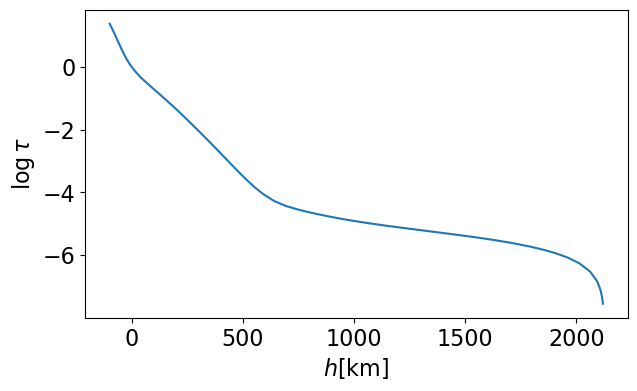

In [10]:
logtau = np.copy(atmos[0])
plt.figure(figsize=[7,4])
plt.plot(z,logtau)
plt.xlabel("$h [{\mathrm {km}}]$")
plt.ylabel("$\log \\tau$")

### Step two: specify source function and optical depth (at multiple wavelengths in the spectrum).

We will now make an ad hoc spectrum. We will now focus on the continuum processes. In order to do that we will scale our optical depth with a wavelength dependent quantity that we already mentioned in the class and called $r_\lambda$.

For the source function we can use the Planck function:

### $$S_\lambda = \frac{2hc^2}{\lambda^5} \frac{1}{e^{hc/\lambda k T} - 1}$$

In [11]:
# So for start we can say, not worrying about the units: 
def Planck_f(llambda, T):

    h = 6.262E-34
    k = 1.38E-23
    c = 3E8

    return 2.0 * h * c **2.0 /llambda**5.0 / (np.exp(h*c/llambda / k /T) - 1.0)

In [12]:
# Now we are going to define a grid of wavelengths: 

llambda = np.linspace(10.0,2000.0,200)*1E-9 # this gives us a uniform wavelength grid

In [13]:
# As an exercise, let's plot the planck function for the range of wavelengths for a desired temperature: 

S_test = Planck_f(llambda, 6000)

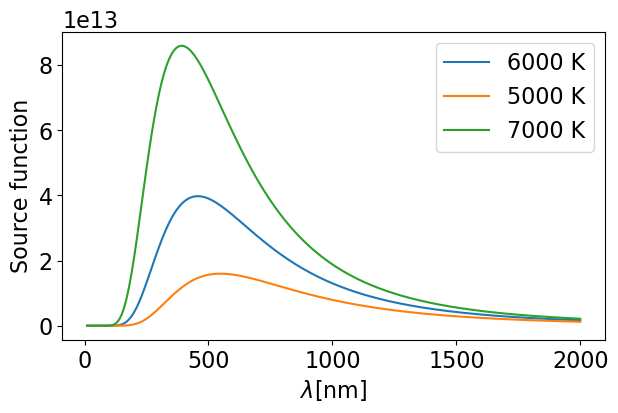

In [16]:
plt.figure(figsize=[7,4])
plt.plot(llambda*1E9,S_test, label='6000 K')
plt.plot(llambda*1E9,Planck_f(llambda, 5000), label='5000 K')
plt.plot(llambda*1E9,Planck_f(llambda, 7000), label='7000 K')
plt.xlabel("$\lambda [{\mathrm {nm}}]$")
plt.ylabel("Source function")
plt.legend()

Looks good! Now we can play a bit with the temperatures and inspect the shape of the Planck function.

### Now, one source function is not enough for us to model the spectrum, we need to solve the RTE

### Step 2.1: Calculate depth-dependent, wavelength dependent optical depth

To do this - we will imitate the bound-free opacity of hydrogen! 

In [18]:
E_ion = 13.6 * 1.6E-19 # ionization energy of Hydrogen from the bound state

h = 6.626E-34
c = 3E8

# This is the wavelength for which hc / lambda = E_ionization

llambda_c1 = h * c / E_ion
print ("Wavelength to ionize the neutral H in the ground state is:", llambda_c1*1E9, " nm")

Wavelength to ionize the neutral H in the ground state is: 91.35110294117648  nm


Now we can make the characteristic shape:

In [19]:
cross_section_1 = (llambda/llambda_c1) ** 3.0
cross_section_1[llambda > llambda_c1] = 0.0

Text(0, 0.5, 'Cross-section (arbitrary units)')

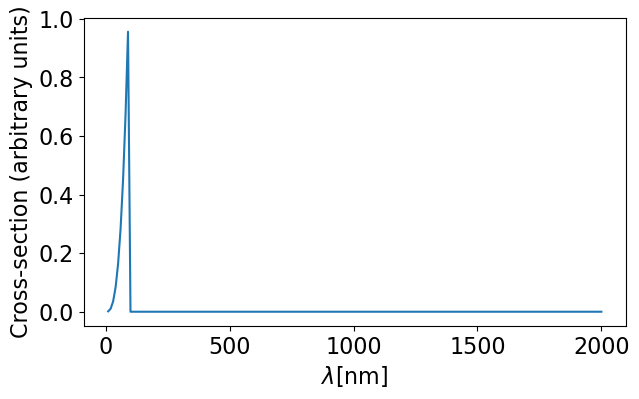

In [20]:
plt.figure(figsize=[7,4])
plt.plot(llambda*1E9,cross_section_1)
plt.xlabel("$\lambda [{\mathrm {nm}}]$")
plt.ylabel("Cross-section (arbitrary units)")

Let's now repeat the process for n = 2, n = 3 and n = 4

In [21]:
llambda_c2 = 4 * h * c / E_ion
llambda_c3 = 9 * h * c / E_ion
llambda_c4 = 16 * h * c / E_ion

cross_section_2 = (llambda/llambda_c2) ** 3.0
cross_section_2[llambda > llambda_c2] = 0.0

cross_section_3 = (llambda/llambda_c3) ** 3.0
cross_section_3[llambda > llambda_c3] = 0.0

cross_section_4 = (llambda/llambda_c4) ** 3.0
cross_section_4[llambda > llambda_c4] = 0.0

Text(0, 0.5, 'Cross-section (arbitrary units)')

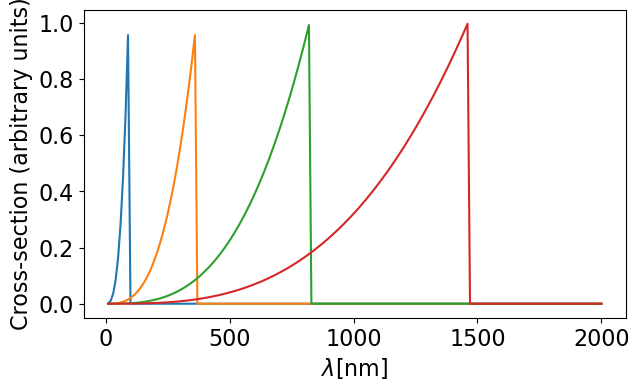

In [26]:
plt.figure(figsize=[7,4])
plt.plot(llambda*1E9,cross_section_1, label="Can ionize i = 1")
plt.plot(llambda*1E9,cross_section_2, label="Can ionize i = 2")
plt.plot(llambda*1E9,cross_section_3, label="Can ionize i = 3")
plt.plot(llambda*1E9,cross_section_4, label="Can ionize i = 4")
plt.xlabel("$\lambda [{\mathrm {nm}}]$")
plt.ylabel("Cross-section (arbitrary units)")
#plt.legend()

We could go to even higher wavelengths now, but these four are more than enough! Now what we want is to scale these somehow to get this $r_\lambda$. 

### Discuss: what would you need to do to get the realistic scaling. 

We can't do that now, instead, we will invent some numbers: 

In [52]:
r_background = 50.0
r_l = (cross_section_1 * 100.0 + cross_section_2 * 20 + cross_section_3 * 10 + cross_section_4 * 5) + r_background
# This background accounts for other sources of opacity for which we crudely assume is wavelength-indepedentent. 
# We will tune this backgroud later
r_l /= r_l[49]

Text(0, 0.5, '$r_\\lambda$')

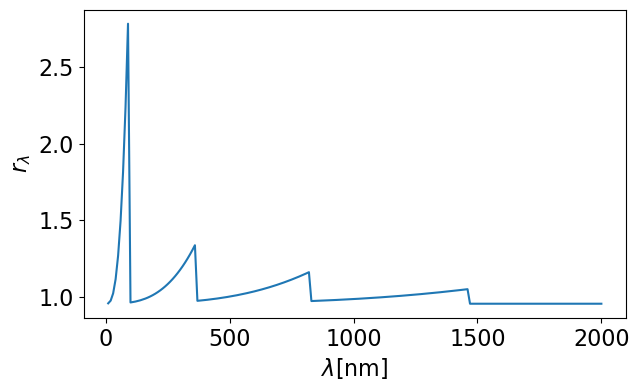

In [53]:
plt.figure(figsize=[7,4])
plt.plot(llambda*1E9,r_l)
plt.xlabel("$\lambda [{\mathrm {nm}}]$")
plt.ylabel("$r_\lambda$")

In [54]:
# Test: 
print(llambda[49] * 1E9)
print(r_l[49])

500.00000000000006
1.0


#### Much better! Now let's calculate the wavelength dependent optical depth for each depth point:

In [55]:
tau_lambda = 10.**(logtau[:,None]) * r_l[None,:]
tau_lambda.shape

(57, 200)

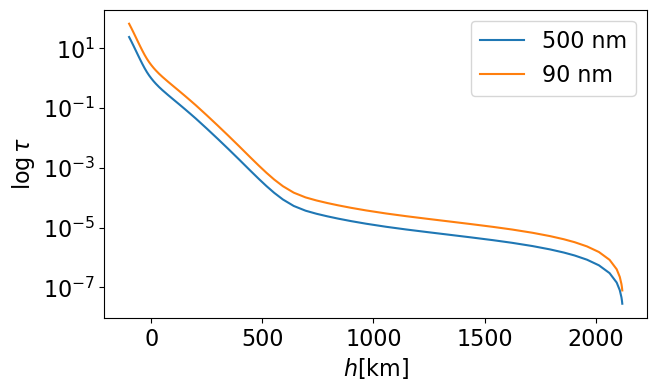

In [56]:
# We can plot the optical depth at two wavelengts to se if this makes sense
plt.figure(figsize=[7,4])
plt.semilogy(z,tau_lambda[:,49],label='500 nm') # continuum
plt.semilogy(z,tau_lambda[:,8],label='90 nm')
plt.xlabel("$h [{\mathrm {km}}]$")
plt.ylabel("$\log \\tau$")
plt.legend()

#### Kinda does! Great! Now, let's go and try to solve radiative transfer equation.

### Step Three : Solving RTE

$$\frac{dI_\lambda}{d\tau_\lambda} = I_\lambda - S_\lambda $$

Now we have $S_\lambda(\tau_\lambda)$ dependency for each wavelenght, so we can solve radiative transfer equation. 

Obviously we need to solve RTE numerically as we have no analytical form of our source function. What do we do? 

Well, we obviously have to devide our atmosphere in series of little "slabs".

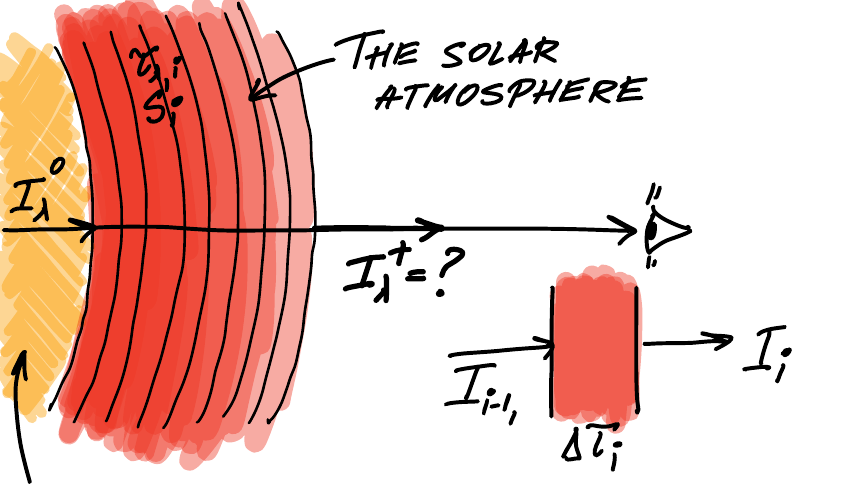

If we assume each slab is homogeneous, for each wavelength and each slab we have: 

### $$ I_i = I_{i+1} e^{-\Delta\tau_i} + S(1-e^{-\Delta\tau_i}) $$

where 

$$S = \frac{S_i + S_{i+1}}{2} $$

Don't be too confused with the idea that we are going from the higher $i$ to the lower $i$, that is just how optical depths work! 

### Let's go! 

In [57]:
# Solving RTE numerically:

S = Planck_f(llambda[None,:], T[:,None])
print (S.shape)

(57, 200)


In [58]:
# What we are going to do here is we will code a "formal solution". which means, we give the code an array of source functions 
# and an array of optical depths at given wavelength, and the code gives us the outoing intensity:

def formal_solution(tau_l, S_l):

    # Infer the number of depths 

    ND = len(tau_l)

    # Define the array that contains the intensities: 
    I = np.zeros(ND)
    # The one at the bottom is just equal to the source function:
    I[-1] = S_l[-1] 
    # Now we need to start going upward and applying the equations from above:
    for d in range(ND-2,-1,-1):
        delta_tau_lambda = tau_l[d+1] - tau_l[d]
        S_mean = 0.5 * (S_l[d+1] + S_l[d])
        I[d] = I[d+1] * np.exp(-delta_tau_lambda) + S_mean * (1.0 - np.exp(-delta_tau_lambda))

    # Return the one coming out of the top: 
    return I[0]

How to test this? Well, we plot the spectrum. What is the spectrum?

### Dependency of emergent intensity on wavelength:

In [61]:
NL = len(llambda)
spectrum2 = np.zeros(NL)
for l in range(0,NL):
    spectrum2[l] = formal_solution(tau_lambda[:,l]/0.5, S[:,l])

Text(0, 0.5, 'Emergent Intensity')

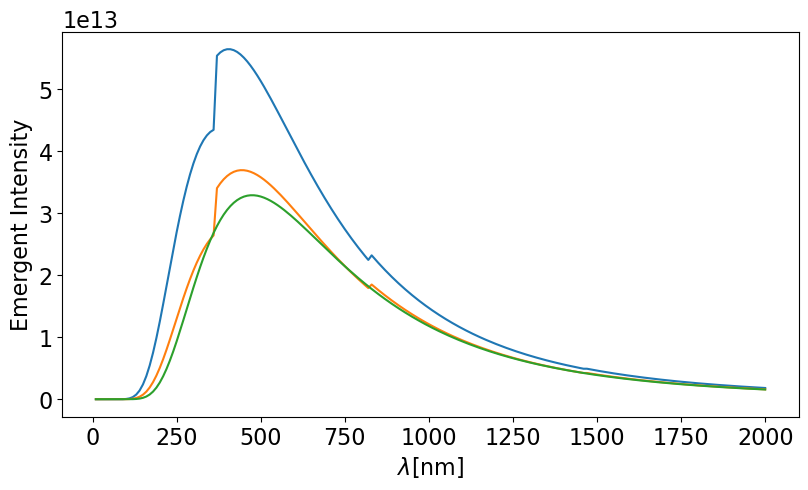

In [62]:
plt.figure(figsize=[9.5,5])
plt.plot(llambda*1E9,spectrum)
plt.plot(llambda*1E9,spectrum2)
plt.plot(llambda*1E9, Planck_f(llambda, 5777))
plt.xlabel("$\\lambda [\mathrm {nm}]$")
plt.ylabel("Emergent Intensity")

### Wow! A spectrum! There are many questions now:

- Which units are these? 
- Why does not not look like the Planck function?
- How does it compare to the real solar spectrum?
- How can we make it look more like the solar spectrum?
- Go back and tweak!
- How to calculate intensity in a different direction?